In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import optuna

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/home/yash/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing Dataset and Preprocessing Data

In [2]:
data = pd.read_csv("train.csv",header=0,index_col=0,parse_dates=[1],date_format="ISO8601")
# Decompose the date column into day, month, and year
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

# Create dummies for categorical columns (including 'year')
categorical_columns = ['country', 'store', 'product', 'year']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=False)

# Drop the original date column
data = data.drop(columns=['date'])*1

In [4]:
data.columns

Index(['num_sold', 'day', 'month', 'country_Canada', 'country_Finland',
       'country_Italy', 'country_Kenya', 'country_Norway', 'country_Singapore',
       'store_Discount Stickers', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Holographic Goose',
       'product_Kaggle', 'product_Kaggle Tiers', 'product_Kerneler',
       'product_Kerneler Dark Mode', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015', 'year_2016'],
      dtype='object')

In [3]:
test_data = pd.read_csv("test.csv", header=0, index_col=0, parse_dates=[1], date_format="ISO8601")

test_data['day'] = test_data['date'].dt.day
test_data['month'] = test_data['date'].dt.month
test_data['year'] = test_data['date'].dt.year

categorical_columns = ['country', 'store', 'product', 'year']
test_data = pd.get_dummies(test_data, columns=categorical_columns, drop_first=False)

test_data = test_data.drop(columns=['date'])

test_data = test_data.reindex(columns=data.columns.drop('num_sold'), fill_value=0)

print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 98550 entries, 230130 to 328679
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   day                         98550 non-null  int32
 1   month                       98550 non-null  int32
 2   country_Canada              98550 non-null  bool 
 3   country_Finland             98550 non-null  bool 
 4   country_Italy               98550 non-null  bool 
 5   country_Kenya               98550 non-null  bool 
 6   country_Norway              98550 non-null  bool 
 7   country_Singapore           98550 non-null  bool 
 8   store_Discount Stickers     98550 non-null  bool 
 9   store_Premium Sticker Mart  98550 non-null  bool 
 10  store_Stickers for Less     98550 non-null  bool 
 11  product_Holographic Goose   98550 non-null  bool 
 12  product_Kaggle              98550 non-null  bool 
 13  product_Kaggle Tiers        98550 non-null  bool 
 14  produ

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230130 entries, 0 to 230129
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   num_sold                    221259 non-null  float64
 1   day                         230130 non-null  int32  
 2   month                       230130 non-null  int32  
 3   country_Canada              230130 non-null  int64  
 4   country_Finland             230130 non-null  int64  
 5   country_Italy               230130 non-null  int64  
 6   country_Kenya               230130 non-null  int64  
 7   country_Norway              230130 non-null  int64  
 8   country_Singapore           230130 non-null  int64  
 9   store_Discount Stickers     230130 non-null  int64  
 10  store_Premium Sticker Mart  230130 non-null  int64  
 11  store_Stickers for Less     230130 non-null  int64  
 12  product_Holographic Goose   230130 non-null  int64  
 13  product_Kaggle     

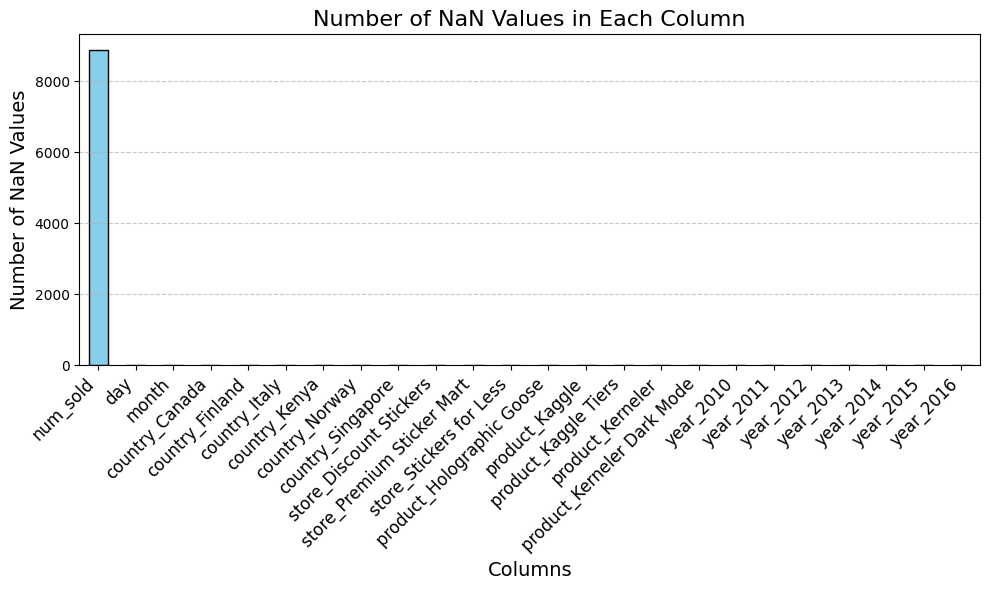

In [6]:
import matplotlib.pyplot as plt

# Count the number of NaN values in each column
nan_counts = data.isna().sum()

# Plot the NaN counts as a bar chart
plt.figure(figsize=(10, 6))
nan_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of NaN Values in Each Column', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Number of NaN Values', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


In [6]:
data = data.dropna(subset=['num_sold'])
X = data.drop(["num_sold"],axis=1)
y = data["num_sold"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=0)

## Running SLRM ## 

In [8]:
from sklearn.linear_model import LinearRegression

X_test_lin_reg = X_test.drop(["country_Canada","store_Stickers for Less","product_Kaggle","year_2010"],axis=1) #droping cols to avoid dummy variable trap
X_train_lin_reg = X_train.drop(["country_Canada","store_Stickers for Less","product_Kaggle","year_2010"],axis=1) #droping cols to avoid dummy variable trap


lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_lin_reg,y_train)
y_pred = lin_reg.predict(X_test_lin_reg)
mean_absolute_percentage_error(y_test, y_pred)

4.485058804831113

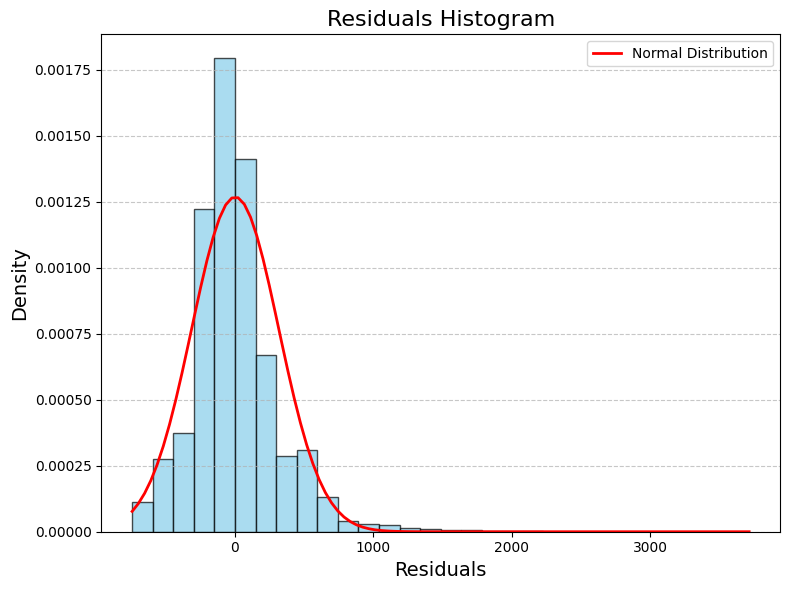

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Calculate residuals
residuals = y_test - y_pred

# Plot the histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black', alpha=0.7, density=True)

# Overlay a normal distribution curve for comparison
mu, std = np.mean(residuals), np.std(residuals)
x = np.linspace(min(residuals), max(residuals), 100)
plt.plot(x, stats.norm.pdf(x, mu, std), color='red', lw=2, label='Normal Distribution')

# Add labels and title
plt.title('Residuals Histogram', fontsize=16)
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


In [10]:
test_lin_reg = X_test.drop(["country_Canada","store_Stickers for Less","product_Kaggle","year_2010"],axis=1) #droping cols to avoid dummy variable trap

y_pred_lin_reg = lin_reg.predict(test_lin_reg)

## Implementing CatBoost Regressor ##

In [7]:
from catboost import CatBoostRegressor

In [12]:
model = CatBoostRegressor(iterations=5000, learning_rate=0.1, depth=6, verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.3331593718117777

In [13]:
y_pred_cat = model.predict(test_data)

In [15]:
test_data.head(2)

,day,month,country_Canada,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,...,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
id,,,,,,,,,,,,,,,,,,,,,
230130,1,1,True,False,False,False,False,False,True,False,...,False,False,False,0,0,0,0,0,0,0
230131,1,1,True,False,False,False,False,False,True,False,...,False,False,False,0,0,0,0,0,0,0


### Hyper Parameter Tuning CayBoost ###

In [10]:
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def objective(trial):
    # Define the hyperparameter search space
    params = {
        "iterations": trial.suggest_int("iterations", 500, 5000, step=500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_strength": trial.suggest_float("random_strength", 1, 10),
        "verbose": 0,
    }

    # Train the CatBoost model
    model = CatBoostRegressor(**params)
    model.fit(
        X_train_split, y_train_split,
        eval_set=(X_valid_split, y_valid_split),
        early_stopping_rounds=50,
        verbose=False
    )

    # Predict on the validation set
    y_pred = model.predict(X_valid_split)

    # Calculate the mean absolute percentage error
    mape = mean_absolute_percentage_error(y_valid_split, y_pred)
    return mape

# Create a study and optimize the objective function
study = optuna.create_study(direction="minimize")  # Minimize MAPE
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters:", study.best_params)
print("Best MAPE:", study.best_value)

[I 2025-01-05 00:44:19,871] A new study created in memory with name: no-name-4f197102-67b7-4f45-819e-0f26d3be1a55
[I 2025-01-05 00:44:25,408] Trial 0 finished with value: 0.18852537433992 and parameters: {'iterations': 500, 'depth': 7, 'learning_rate': 0.08104758124474824, 'l2_leaf_reg': 2.0092788809710997, 'bagging_temperature': 0.7932501613386246, 'random_strength': 7.017960395941906}. Best is trial 0 with value: 0.18852537433992.
[I 2025-01-05 00:45:05,965] Trial 1 finished with value: 0.3304564096115546 and parameters: {'iterations': 5000, 'depth': 4, 'learning_rate': 0.2288112032045392, 'l2_leaf_reg': 9.503297607110548, 'bagging_temperature': 0.685569558634021, 'random_strength': 8.301416906881336}. Best is trial 0 with value: 0.18852537433992.
[I 2025-01-05 00:45:27,314] Trial 2 finished with value: 0.20988760814908233 and parameters: {'iterations': 1500, 'depth': 9, 'learning_rate': 0.0424936118590121, 'l2_leaf_reg': 6.201776704051449, 'bagging_temperature': 0.4254317125146371, 

Best hyperparameters: {'iterations': 1000, 'depth': 10, 'learning_rate': 0.016836815337439724, 'l2_leaf_reg': 9.959375804473451, 'bagging_temperature': 0.4468602108566648, 'random_strength': 5.134787015409818}
Best MAPE: 0.1334752748703182


In [11]:
best_params = study.best_params
final_model = CatBoostRegressor(**best_params, verbose=0)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Calculate and display MAPE
final_mape = mean_absolute_percentage_error(y_test, y_pred)
print("Final MAPE on test data:", final_mape)

Final MAPE on test data: 0.13185682394267637


In [13]:
y_pred_cat = final_model.predict(test_data)

## Implementing Extra Trees Regressor ##

In [4]:
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor,ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

In [17]:
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def objective(trial):
    #defining the search space
    params = {
        "splitter": ["random","best"],
        "max_depth": trial.suggest_int("max_depth", 1,15),
        "min_samples_split": trial.suggest_float("min_samples_split",0,1),
        "min_samples_leaf": trial.suggest_float("min_samples_leaf",0,1),
        "min_weight_fraction_leaf": trial.suggest_float("min_weight_fraction_leaf",0,0.5),
        "max_features": trial.suggest_float("max_features",0,1)
    }

    model = ExtraTreesRegressor()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mape

# Create a study and optimize the objective function
study = optuna.create_study(direction="minimize",storage="sqlite:///etr.sqlite3",)  # Minimize MAPE
study.optimize(objective, n_trials=5)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters:", study.best_params)
print("Best MAPE:", study.best_value)

[I 2025-01-05 17:27:58,299] A new study created in RDB with name: no-name-3776bf25-485f-43a3-b268-33cb9f27bcdc
[I 2025-01-05 17:29:39,550] Trial 0 finished with value: 0.07982122745716144 and parameters: {'max_depth': 15, 'min_samples_split': 0.10242587324212105, 'min_samples_leaf': 0.5932486525052405, 'min_weight_fraction_leaf': 0.179095421582253, 'max_features': 0.13032254507638363}. Best is trial 0 with value: 0.07982122745716144.
[I 2025-01-05 17:31:23,737] Trial 1 finished with value: 0.07977312774788378 and parameters: {'max_depth': 8, 'min_samples_split': 0.23866483493169188, 'min_samples_leaf': 0.6102867969357157, 'min_weight_fraction_leaf': 0.22399533333682925, 'max_features': 0.3579405104836205}. Best is trial 1 with value: 0.07977312774788378.
[I 2025-01-05 17:33:02,282] Trial 2 finished with value: 0.07978501721778958 and parameters: {'max_depth': 9, 'min_samples_split': 0.0339037069248358, 'min_samples_leaf': 0.9130087399666282, 'min_weight_fraction_leaf': 0.36585527005966

Best hyperparameters: {'max_depth': 8, 'min_samples_split': 0.23866483493169188, 'min_samples_leaf': 0.6102867969357157, 'min_weight_fraction_leaf': 0.22399533333682925, 'max_features': 0.3579405104836205}
Best MAPE: 0.07977312774788378


In [18]:
hyperparameters = {
    'max_depth': 5,
    'min_samples_split': 0.18426879397874685,
    'min_samples_leaf': 0.46150280476956684,
    'max_features': 0.23522763475803943,
    'n_estimators': 100,  # Default number of trees, can adjust as needed
    'random_state': 42
}

# Train the ExtraTrees Regressor
model = ExtraTreesRegressor(**study.best_params)
model.fit(X_train, y_train)
y_pred_etr = model.predict(test_data)

## Predictions ##

In [16]:
predictions = pd.DataFrame({
    'id': test_data.index,  # Use the index as the IDs
    'num_sold': y_pred_etr  # Add the predictions as 'num_sold'
})

predictions.to_csv("predictions.csv", index=False)